# Ground-State Variational Search with NetKet for a FREE Bosonic Matrix Model

September 1, 2021 

In this Tutorial we will use the open-source package [NetKet](https://www.netket.org/) to find the ground state (in a variational sense) of a quantum mechanical system of matrices, which can be seen as a chain of harmonic oscillators.
This system is referred to as a free bosonic matrix model and was studied in [this preprint](https://arxiv.org/abs/2108.02942) (setting the coupling constant to zero). 

Specifically, we will study the system defined by the Hamiltonian: 

$$ \hat{H} = {\rm Tr}\left(\frac{1}{2}\hat{P}_I^2+\frac{m^2}{2}\hat{X}_I^2\right) $$

where 
$$\hat{P}_I=\sum_{\alpha=1}^{N^2-1}\hat{P}_I^\alpha\tau_\alpha$$

and

$$\hat{X}_I=\sum_{\alpha=1}^{N^2-1}\hat{X}_I^\alpha\tau_\alpha$$

for a SU(N) gauge group with $N^2-1$ generators.

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment (e.g. with `conda`) and install NetKet within (using `pip`): 

```bash
conda create --name netket python pip ipython
conda activate netket
pip install --upgrade netket
```

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
!pip install --upgrade netket

You can check that the installation was succesfull doing 

In [2]:
import netket as nk

You should also check that your version of netket is at least 3.0

In [3]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.0.1


In [4]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). This is done specifying the Hilbert space of the problem.

For our problem we focus on the gauge group SU(2), which will determine the total number of bosons to be $N^2-1 = 3$ for each matrix. We will focus on 2 matrices, for a total of 6 bosonic degrees of freedom.

We also need to decide a cutoff for the Fock space of each boson $\Lambda$.

(We are also setting the mass $m$ parameter to 1. The Hamiltonian is then a simple sum over harmonic oscillators with unit frequency $\omega_i=1$)

### 1.1 The Hilbert space

Our degrees of freedom can be exchanged without changing the Hamiltonian (it is a sum of all the terms, thus symmetric under exchange). 
We can use the graph functionalities of `netket` (which are originally designed for spatial symmetries) to build the Hilbert space corresponding to our system.

If we consider $N$ bosonic sites, with an exchange symmetry (permutation), we can write them down as a set (a graph with nodes and no edges)

In [5]:
N = 6  # number of bosons 

# graph with no edges
sites = nk.graph.Edgeless(list(range(N)))

print(f"Number of sites: {sites.n_nodes}")

Number of sites: 6


Graphs have a built-in methods to inspect their symmetries (for a permutation group with 6 elements this should be $6!=6\cdot5\cdot4\cdot3\cdot2=720$)

In [6]:
symmetries = sites.automorphisms()
print(f"Nmber of permutations: {len(symmetries)}")

Nmber of permutations: 720


We then construct the Hilbert space (we could use the graph but for `Fock` spaces this is deprecated in `netket` v3.0)

In [7]:
Lambda = 4  # cutoff of each bosonic Fock space

hi = nk.hilbert.Fock(n_max=Lambda-1, N=N)  # n_max -> Maximum occupation for a site (inclusive)

Test if the space is constructed as we expected.
We want each of the $N$ bosons to have up to $\Lambda$ excitations: the total Hilbert space is the tensor product of $N$ individual Fock spaces of dimension $\Lambda$ for a total size of $\Lambda^N = 4^6 = 4096$.

In [8]:
# The size of the hilbert space on every site.
hi.shape

(4, 4, 4, 4, 4, 4)

In [9]:
# The total number number of degrees of freedom.
hi.size

6

In [10]:
# The total dimension of the many-body Hilbert space
hi.n_states

4096

We have checked that all the dimensions correspond to our expectations. We can think of this as the Hilbert state of a mnay-body system with $N$ sites of bosons, each with excitations up to level $\Lambda$ (inclusive, starting from 0 to $\Lambda-1$).

### 1.2 The free Hamiltonian

We now need to specify the Hamiltonian.
We will use some predefined operators for bosons, such as the `create` and `destroy` operators for each boson in the Hilber state (see the API documentation [here](https://www.netket.org/docs/api.html#pre-defined-operators)).

In this specifc case, $\hat{a}^\dagger_I$ and $\hat{a}_I$ for each boson $I$ (we can regard this index as the _site_ index in `netket`).



In [11]:
from netket.operator.boson import create, destroy

We define the free part of the Hamiltonian, which is just a collection of harmonic oscillators.
Instead of using the `nk.operator.GraphOperator`, where we need to pass the Hilbert space, the graph structure, and a list of operators for each site and edge (if present), we simply use a `LocalOperator`.
In fact, we only have site operators, which are the _number_ operator for each boson (harmonic oscillator), summed over all sites.


In [12]:
# we loop over all "sites" -> loop over N bosons
H = sum([0.5+create(hi,i)*destroy(hi,i) for i in range(N)])

In [38]:
H

LocalOperator(dim=6, acting_on=[[0], [1], [2], [3], [4], [5]], constant=3.0, dtype=float64)

In general, when manipulating NetKet objects, you should always assume that you can safely operate on them like 
you would in mathematical equations, therefore you can sum and multiply them with ease.

## 2. Exact Diagonalization

Let us check this free Hamiltonian, whose eigenvectors are analytically known: the ground state has vacuum energy for $N$ independent harmonic oscillators: $0.5N = 0.5 \cdot 6 = 3$ 

`netket` provides a wrapper for `eigsh` in the form of a Lanczos [exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.lanczos_ed.html#netket.exact.lanczos_ed).

In [13]:
eig_vals = nk.exact.lanczos_ed(H, k=1, compute_eigenvectors=False)  # args to scipy.sparse.linalg.eighs like can be passed with scipy_args={'tol':1e-8}
print(f"Eigenvalues with exact lanczos (sparse): {eig_vals}")

Eigenvalues with exact lanczos (sparse): [3.]


*Note*: a full (dense) exact diagonalization can also be done for small systems using [this exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.full_ed.html#netket.exact.full_ed)

In [14]:
w = nk.exact.full_ed(H, compute_eigenvectors=False)
print(f"Eigenvalues with exact diag (dense): {w}\nNumber of eigs: {w.shape[0]}")

Eigenvalues with exact diag (dense): [ 3.  4.  4. ... 20. 20. 21.]
Number of eigs: 4096


## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(X_i), $$

where the variational parameters are individual boson's wave functions $\Phi(X_i)$. This is probably a bad ansatz, but it will show how the variational Monte Carlo procedure works in `netket`

We can further write $ \Phi(X) = \sqrt{P(X)}e^{i \phi(X)}$.

In order to simplify the presentation, we take here and in the following examples the phase $\phi=0$.

For the normalized single-boson probability we will take a sigmoid form: 

$$P(X; \gamma) = 1/(1 + e^{-\gamma X})$$
thus depending on the real-valued variational parameter $\gamma$. 

In `netket` one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \exp{(\textrm{Model}(X; \theta))} $$

where $\theta$ is a set of parameters.

In this case, the parameter of the model will be just one: $\gamma$.

The Model can be defined using one of the several functional jax frameworks such as Jax/Stax, Flax or Haiku. NetKet includes several pre-built models and layers built with Flax, so we will be using it for the rest of the notebook.

In [15]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        gam = self.param(
            "gamma", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(gam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

### 3.1 Variational State

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To actually create a **variational state** with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 

To do this, we first need to define a sampler.

In [`netket.sampler`](https://www.netket.org/docs/api.html#list-of-samplers) several samplers are defined, each with its own peculiarities.

In the following example, we will be using a simple sampler that chooses the occupation number of each boson at random (uniform between 0 and $\Lambda-1$) one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [16]:
# Create an instance of the model. 
# Notice that this does not create the parameters.
mf_model=MF()

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=500)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters

In [17]:
# you can inspect the parameters which contain the single
# variational parameter `gamma`
print(vstate.parameters)

FrozenDict({
    gamma: DeviceArray([-0.00850367], dtype=float64),
})


In [18]:
# Expectation value: notice that it also provides an error estimate.
print(vstate.expect(H))

11.63 ± 0.12 [σ²=6.78, R̂=1.0038]


The last cell was run with a randomly initialized parameter $\gamma$ and for 500 samples (notice the metrics for the convergence of the Monte Carlo algorithm in square brackets).

## 4. Variational Monte Carlo

We will now try to optimise $ \gamma $ in order to best approximate the ground state of the hamiltonian.

To do so, first I need to pick an iterative optimiser. We choose stochastic gradient descent with a learning
rate of $0.05$.
Then, we must provide all the elements to the variational monte carlo driver, which takes case of setting up and running the whole optimisation.

For example, the driver can be run for a specific number of iterations. Each iteration will have to run the Monte Carlo sampling defined by the variational state `nk.vqs.MCState`.

In [19]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

# expectation value of the energy
mf_energy=vstate.expect(H)
# compare with the Lanczos exact diagonalization energy eigenvalue
error=abs((mf_energy.mean-eig_vals[0])/eig_vals[0])
print("Optimized energy and relative error: ",mf_energy,error)

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████| 300/300 [00:06<00:00, 47.69it/s, Energy=3.211 ± 0.020 [σ²=0.209, R̂=1.0780]]


Optimized energy and relative error:  3.117 ± 0.018 [σ²=0.166, R̂=1.0236] 0.03906250000000123


In [20]:
# we can also inspect the parameter:
print("Final optimized parameter: ",vstate.parameters["gamma"])

Final optimized parameter:  [-4.46282365]


In [21]:
print(f"Final optimized energy relative error (with mean-field ansatz): {error*100:.2f}%")

Final optimized energy relative error (with mean-field ansatz): 3.91%


Even a very rudimentary ansatz without interactions between the degrees of freedom is sufficient to reach a 3% error on the ground state energy with a single parameter to optimize.

We would expect that we can recover the correct ground state for harmonic oscillators.

## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields about 3% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz where the states of the individual bosons are connected. 

We will now take a short-range Jastrow ansatz which is already inlcuded in `netket` as [`nk.models.Jastrow`](https://www.netket.org/docs/_generated/models/netket.models.Jastrow.html#netket.models.Jastrow):

$$\log{\Psi(X)} = \sum_{ij} X_i W_{ij} X_j$$

where $W_{ij}$ is a symmetric matrix of learnable complex parameters (the _kernel_ of the quadratic form).

In [22]:
# change the model: initialize weights with normal distributions
model=nk.models.Jastrow(kernel_init=nn.initializers.normal())

# we use the same MetropolicLocal sapmler as before. Now we sample for longer to get a more accurate result
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

In [23]:
# look at the parameters: How many do we have?
print(vstate.n_parameters)

36


We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner:

In [24]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

# driver for running the simulation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=preconditioner)

We now log the intermediate results of the optimization, so that we can visualize them at a later stage. 

In [25]:
# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)


100%|██████████| 300/300 [00:08<00:00, 37.01it/s, Energy=3.0050+0.0000j ± 0.0022 [σ²=0.0049, R̂=1.0071]]


(<netket.logging.runtime_log.RuntimeLog at 0x12a3d0b20>,)

In [26]:
print(f"Final optimized kernel parameters: {vstate.parameters['kernel']}\n")
jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error*100:.2f}%")

Final optimized kernel parameters: [[-1.61855132-0.00248893j -0.16888671-0.00902151j -0.1640647 -0.0046593j
  -0.17198388+0.00122121j -0.17368407+0.01111708j -0.15520154+0.00636135j]
 [-0.17528343+0.00428773j -1.61144277-0.0015409j  -0.15080412-0.00559624j
  -0.16447051+0.01028026j -0.14645449-0.00459254j -0.16980206-0.00457055j]
 [-0.15492868-0.00096187j -0.16206466+0.00131015j -1.60923369+0.00364165j
  -0.15843458+0.00273141j -0.15267161-0.00108149j -0.16786889-0.00501821j]
 [-0.15542047+0.00814621j -0.15571381+0.00417769j -0.17129117-0.00532878j
  -1.59114407-0.00087357j -0.15878891-0.01011895j -0.15714192+0.01788576j]
 [-0.16412385+0.01314771j -0.14895734+0.01072716j -0.1595719 -0.00423222j
  -0.15278502+0.00787217j -1.61415629+0.01116552j -0.16195748+0.00365997j]
 [-0.1560094 +0.00103035j -0.16538598-0.00961883j -0.17053382+0.00884113j
  -0.16699551-0.00275465j -0.16175821-0.00115097j -1.60311075+0.00159993j]]

Optimized energy : 3.000e+00+0.000e+00j ± nan [σ²=0.000e+00]
relative 

You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 
This ansatz has more parameters (we went from 1 to 36).

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in `netket`, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

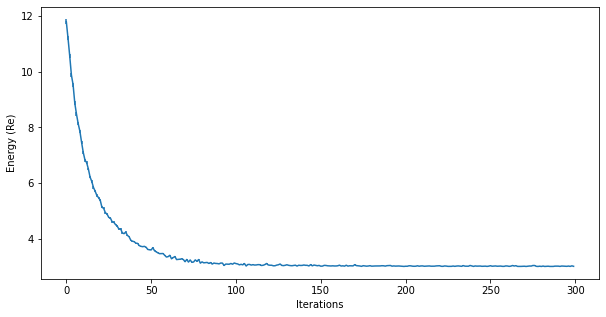

In [27]:
data_jastrow = log.data
energy_history = data_jastrow["Energy"]["Mean"].real
energy_error_history = data_jastrow["Energy"]["Sigma"]

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, energy_history, yerr=energy_error_history)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

You can also look at the MCMC chain properties

Text(0.5, 0, 'Iterations')

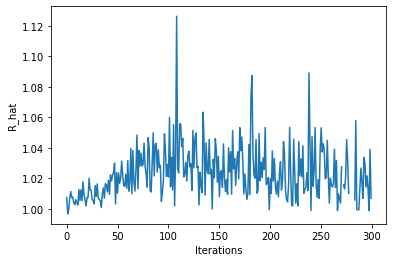

In [28]:
plt.plot(data_jastrow["Energy"].R_hat)
plt.ylabel("R_hat")
plt.xlabel("Iterations")

Some chains have `R_hat` larger than ones, which means they might not have converged within the 1000 samples that we had specified...

## 6. Neural-Network Quantum State 

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [29]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module. This is the ratio of neurons to input dofs
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nk.nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
        
        # sum the output
        return jnp.sum(y, axis=-1)

In [30]:
# it is easy here to pass the hyper-parameter value
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

print(f"Number of parameters for this model: {vstate.n_parameters}")

Number of parameters for this model: 42


We then proceed to the optimization as before. 

In [31]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=preconditioner)

# logging and running
log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")

100%|██████████| 300/300 [00:06<00:00, 45.89it/s, Energy=3.000e+00 ± nan [σ²=0.000e+00, R̂=inf]]


Optimized energy: 3.000e+00 ± nan [σ²=0.000e+00, R̂=inf] 
Relative error: 0.00%


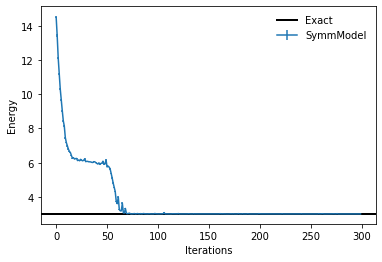

In [32]:
# last iterations only
last = 300
ffn_data = log.data
its = ffn_data["Energy"].iters[-last:]
ene = ffn_data["Energy"]["Mean"].real[-last:]
err = ffn_data["Energy"]["Sigma"][-last:]

plt.errorbar(its,ene,yerr=err,label="SymmModel")
plt.axhline(y=eig_vals[0], xmin=0, xmax=ffn_data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

## 7. Enforcing Symmetry 

In order to enforce symmetries we can use some built-in functionalities of graphs in `netket`, in conjunction with equivariant layers.

We have already constructed a graph (using `nk.graph.Edgless`) for our Hamiltonian and we have seen its symmetry group, the permutation group.

We now write a model with an invariant transformation given by the permutation group. Notice that we will now use `netket`'s own ```nn``` module, instead of Flax, since it contains several additions and also an extended and seamless support for complex layers/parameters.  

In [33]:
import netket.nn as nknn

class SymmModel(nn.Module):
    alpha: int

    @nn.compact
    def __call__(self, x):
        
        x = nknn.DenseSymm(symmetries=sites.automorphisms(),
                           features=self.alpha,
                           kernel_init=nk.nn.initializers.normal(stddev=0.01))(x)
        x = nn.relu(x)

        # sum the output
        return jnp.sum(x,axis=(-1,-2))

In [34]:
# define again the sampler
sampler = nk.sampler.MetropolisLocal(hi)

#Let us define a model with 1 feature per symmetry
model=SymmModel(alpha=1)

# define again the variational MC state
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

# print the number of parameters
print(f"Number of parameters for this model: {vstate.n_parameters}")

Number of parameters for this model: 7


As it can be seen, the number of parameters of this model is greatly reduced, because of the symmetries that impose constraints on the weights of the dense layers. We can now optimize the model

In [35]:
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=preconditioner)

log=nk.logging.RuntimeLog()
gs.run(n_iter=300,out=log)

symm_energy=vstate.expect(H)
error=abs((symm_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {symm_energy} \nRelative error: {error*100:.2f}%")

100%|██████████| 300/300 [00:26<00:00, 11.12it/s, Energy=3.000e+00 ± nan [σ²=0.000e+00, R̂=inf]]


Optimized energy: 3.000e+00 ± nan [σ²=0.000e+00, R̂=inf] 
Relative error: 0.00%


This seems like a very precise result.

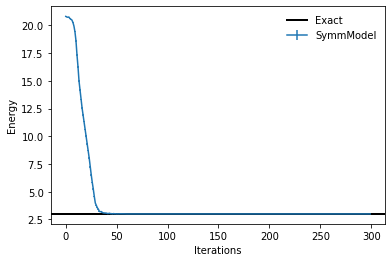

In [77]:
# last iterations only
last = 300
symm_data = log.data
its = symm_data["Energy"].iters[-last:]
ene = symm_data["Energy"]["Mean"].real[-last:]
err = symm_data["Energy"]["Sigma"][-last:]

plt.errorbar(its,ene,yerr=err,label="SymmModel")
plt.axhline(y=eig_vals[0], xmin=0, xmax=symm_data["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend(frameon=False)

With 6 times less parameters than the fully-connected feed-forward neural network ansatz (because we can exchange the 6 sites and the answer should not change, which is our enforced symmetry) we can reach an equally good, if not better, results in less iterations.

## 8. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could measure the generators of the gauge transformations.

We could also use a larger number of samples to have a sufficiently low error bar on their measurement, by changing `vstate.n_samples` on the fly.


The Casimir operator for the gauge group is defined using a combination of $\hat{a}^\dagger_I$ and $\hat{a}_I$ for each boson 

In [36]:
g_list = [0] * 3
g_list[0] = 1j * (
    create(hi,1) * destroy(hi,2)
    - create(hi,2) * destroy(hi,1)
    + create(hi,4) * destroy(hi,5)
    - create(hi,5) * destroy(hi,4)
)
g_list[1] = 1j * (
    create(hi,2) * destroy(hi,0)
    - create(hi,0) * destroy(hi,2)
    + create(hi,5) * destroy(hi,3)
    - create(hi,3) * destroy(hi,5)
)
g_list[2] = 1j * (
    create(hi,0) * destroy(hi,1)
    - create(hi,1) * destroy(hi,0)
    + create(hi,3) * destroy(hi,4)
    - create(hi,4) * destroy(hi,3)
)
G = sum([g * g for g in g_list])

In [37]:
G

LocalOperator(dim=6, #acting_on=9 locations, constant=0, dtype=complex128)

Since the ground state is gauge invariant, we expect the expectation value of `G` to be zero

In [39]:
vstate.expect(G)

0.000e+00+0.000e+00j ± nan [σ²=0.000e+00]